Uses phase_desc_ext

- Compute semantic similarity between abstracts and phase descriptions (from phase_desc.json)
- Combine similarity with query-based priors to assign phases
- Analyze phase distributions and confidence

Results:
- Semantic phase probabilities are generally low and close together → weak semantic separation
- Phase 3 (Optimization) becomes dominant for most abstracts when using normal phase_desc.
- Phase 1 is equally dominant when using extended phase_desc.
- Query-based priors strongly influence the final phase assignment, since the semantic separation is so weak.
- The written phase descriptions also becomes too influential. 

Regarding the results:
- This is not necessarily wrong (that most ML-for-manufacturing research focuses on optimization)
- However, clearer and more detailed phase descriptions are likely needed
- A bibliometric clustering step should also be introduced before lifecycle phase mapping to reveal natural topic structure in the literature

In [4]:
# Imports

import json
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Paths

data_path = Path("../../data/short-raw-refs-abs")
processed_abstracts_path = Path("../../data/processed/abstracts")
phase_config_path = Path("../../phases/phase_desc_ext.json")
save_path = processed_abstracts_path / "semantic_analysis_ext_desc"
figure_path = Path("../../reports/figures/plc_semantic_analysis")
table_path = Path("../../reports/tables/plc_semantic_analysis")


# Ensure directories exist
for p in [data_path, processed_abstracts_path, save_path, figure_path, table_path]:
    p.mkdir(parents=True, exist_ok=True)

print("All directories verified/created.")


All directories verified/created.


In [3]:
# Load abstracts dataset

abstracts_path = processed_abstracts_path / "abstracts.csv"
df = pd.read_csv(abstracts_path)

print(f"Loaded {len(df)} abstracts from {df['query_id'].nunique()} queries.")
df.head()

Loaded 52290 abstracts from 24 queries.


,query_id,eid,doi,title,abstract,clean_abs
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,"Indeed, highly efficient systems do not always..."
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",The detection and localization of quality-rela...
2,ml_anomaly_detection_production,2-s2.0-105016669957,10.1007/978-3-032-04200-2_5,Intelligent Defect Detection for Manufacturing...,"© The Author(s), under exclusive license to Sp...","In modern Industry, I4.0, artificial intellige..."
3,ml_anomaly_detection_production,2-s2.0-85218693791,10.1038/s41598-025-90810-w,Hybrid machine learning framework for predicti...,© The Author(s) 2025.The critical necessity fo...,The critical necessity for sophisticated predi...
4,ml_anomaly_detection_production,2-s2.0-105018301117,10.1016/j.comnet.2025.111753,BGP anomaly detection using the raw internet t...,© 2025 The AuthorsThe Border Gateway Protocol ...,"Hence, detecting any anomaly concerning BGP an..."


In [4]:
# Count how many rows each query_id has
query_counts = df["query_id"].value_counts().to_dict()

# Create a copy and map the counts to each row
df = df.copy()
df["query_size"] = df["query_id"].map(query_counts)

# Sort so that query groups with fewer rows are prioritized
df_sorted = df.sort_values(by="query_size", ascending=True)

# Remove duplicate DOIs, keeping the one in the smallest query group
df_dedup = df_sorted.drop_duplicates(subset="doi", keep="first").drop(columns=["query_size"])

# Print results
print("Original dataset size:", len(df))
print("After removing duplicates:", len(df_dedup))
print("Remaining duplicate DOIs:", df_dedup["doi"].duplicated().sum())

df = df_dedup

Original dataset size: 52290
After removing duplicates: 33130
Remaining duplicate DOIs: 0


In [5]:
# Load phase descriptions from JSON

with phase_config_path.open("r", encoding="utf-8") as f:
    phases = json.load(f)

phase_ids = list(phases.keys())
phase_texts = [phases[p]["description"] for p in phase_ids]

for pid, ptext in zip(phase_ids, phase_texts):
    print(f"{pid}: {ptext[:80]}...")


phase_1: Research and activities before detailed design or production setup. Focus on def...
phase_2: Designing products and implementing production systems. Includes detailed engine...
phase_3: Continuous improvement of established products or production processes using ope...
phase_4: Focus on products in operation or at end-of-life. Activities include field data ...


In [6]:
# Phase priors per query_id
# Format: [Phase1_Planning, Phase2_Development/Production, Phase3_Optimization, Phase4_Use/Reuse]

phase_priors = {
    # Use / Reuse — dominant Phase 4
    "ml_inservice_monitoring":       [0.05, 0.20, 0.35, 0.40],
    "ml_remanufacturing":            [0.05, 0.10, 0.15, 0.70],
    "ml_disassembly":                [0.05, 0.25, 0.20, 0.50],
    "ml_end_of_life":                [0.05, 0.10, 0.15, 0.70],
    "ml_recycling_manufacturing":    [0.05, 0.30, 0.20, 0.45],
    "ml_sustainability_product":     [0.30, 0.10, 0.10, 0.50],

    # Very broad — spans production & optimization
    "ml_manufacturing":              [0.10, 0.45, 0.40, 0.05],

    # Planning phase focus
    "ml_planning_production":        [0.75, 0.15, 0.10, 0.00],
    "ml_product_design":             [0.80, 0.15, 0.05, 0.00],
    "ml_plm":                        [0.40, 0.10, 0.15, 0.35],  # lifecycle both ends

    # Development / Production execution focus
    "ml_product_development":        [0.20, 0.60, 0.20, 0.00],
    "ml_defect_detection":           [0.10, 0.65, 0.25, 0.00],
    "ml_quality_control":            [0.05, 0.55, 0.40, 0.00],
    "ml_automation":                 [0.05, 0.70, 0.25, 0.00],
    "ml_robotics_production":        [0.05, 0.75, 0.20, 0.00],

    # Supply chain → planning weighted, but still operational relevance
    "ml_supply_chain":               [0.45, 0.35, 0.15, 0.05],

    # Optimization focused
    "ml_manufacturing_optimization": [0.05, 0.25, 0.70, 0.00],
    "ml_production_optimization":    [0.05, 0.25, 0.70, 0.00],
    "ml_process_optimization":       [0.05, 0.25, 0.70, 0.00],
    "ml_process_control":            [0.05, 0.20, 0.75, 0.00],
    "ml_process_modeling":           [0.10, 0.20, 0.70, 0.00],
    "ml_predictive_maintenance":     [0.05, 0.20, 0.60, 0.15],
    "ml_anomaly_detection_production":[0.05, 0.20, 0.70, 0.05],

    # Use / Reuse specific — RUL informs lifetime while still in operation
    "ml_rul":                        [0.05, 0.15, 0.30, 0.50],
}



def get_phase_prior(query_id):
    # Return a valid probability vector for the query
    prior = phase_priors.get(query_id)
    if prior is None:
        # Default weakly uniform prior if unknown query_id
        prior = np.array([0.25, 0.25, 0.25, 0.25], dtype=float)
    else:
        prior = np.array(prior, dtype=float)
        prior = prior / prior.sum()
    return prior


In [ ]:
# Define embedding and similarity helpers (to be implemented with your chosen model)

model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")  # In use
# light_model = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2")

def get_embedding(text):
    if not isinstance(text, str):
        text = ""
    emb = model.encode(
        text,
        show_progress_bar=False,
        convert_to_numpy=True,
        normalize_embeddings=True,
    )
    return emb

def cosine_similarity(a, b):
    # Compute cosine similarity between two 1D vectors
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    if denom == 0:
        return 0.0
    return float(np.dot(a, b) / denom)


In [39]:
# Extract the tokenizer tied to the embedding model
tokenizer = model.tokenizer

# Get maximum number of tokens the model can handle per input
max_len = model.get_max_seq_length()

def embed_with_chunking(text, max_len=max_len):
    """
    Compute an embedding for text that may exceed the model's max input length.
    If the text is short enough, embed normally. If too long, split it into
    chunks that fit within the model limit, embed each chunk, and average them.
    
    This prevents information loss from naive truncation.
    """

    # Convert the raw text into wordpiece tokens
    tokens = tokenizer.tokenize(text)

    # If the number of tokens is within allowed max length -> embed directly
    if len(tokens) <= max_len:
        # Simple case: return a single embedding
        return get_embedding(text)

    # For long inputs: split the tokens into smaller chunks
    # Each chunk has a length <= max_len to avoid truncation during encoding
    chunks = [
        tokenizer.convert_tokens_to_string(tokens[i:i+max_len])
        for i in range(0, len(tokens), max_len)
    ]

    # Encode each chunk separately and collect the resulting embeddings
    # get_embedding already handles model encoding + normalization
    emb_chunks = [get_embedding(chunk) for chunk in chunks]

    # Aggregate the chunk embeddings into a single representation
    # Mean pooling is commonly used and keeps vector dimensions intact
    emb_mean = np.mean(emb_chunks, axis=0)

    # Return the final merged embedding for this abstract/text
    return emb_mean


In [8]:
# Precompute embeddings for all phase descriptions

phase_embeddings = []
for pid, ptext in zip(phase_ids, phase_texts):
    emb = get_embedding(ptext)
    phase_embeddings.append(emb)

phase_embeddings = np.vstack(phase_embeddings)
phase_embeddings.shape


(4, 768)

In [40]:
# Compute semantic phase scores for each abstract with progress bar

sim_cols = ["sim_phase_1", "sim_phase_2", "sim_phase_3", "sim_phase_4"]

# Initialize columns
for col in sim_cols:
    df[col] = np.nan

batch_size = 512  # Adjust based on GPU memory

for start in tqdm(range(0, len(df), batch_size), desc="Embedding abstracts"):
    end = min(start + batch_size, len(df))
    batch = df.iloc[start:end]

    sims = []
    for text in batch["clean_abs"].astype(str).tolist():
        e_abs = embed_with_chunking(text)
        sim_vec = [cosine_similarity(e_abs, pe) for pe in phase_embeddings]
        sims.append(sim_vec)

    sims = np.array(sims)
    exp_sims = np.exp(sims - sims.max(axis=1, keepdims=True))
    probs = exp_sims / exp_sims.sum(axis=1, keepdims=True)

    df.loc[batch.index, sim_cols] = probs

print("Semantic phase scores computed.")
df[sim_cols].head()


Embedding abstracts: 100%|██████████| 65/65 [07:12<00:00,  6.66s/it]

Semantic phase scores computed.


,sim_phase_1,sim_phase_2,sim_phase_3,sim_phase_4
3373,0.245033,0.254934,0.234171,0.265862
3374,0.233222,0.251500,0.235950,0.279328
3387,0.247294,0.245654,0.246030,0.261022
3388,0.254648,0.245610,0.249727,0.250015
3389,0.238154,0.238922,0.242455,0.280469


In [41]:
# Combine query priors and semantic scores into final phase probabilities

alpha = 0.0 # Weight on priors (0=only semantics, 1=only priors)

final_cols = ["phase_p1", "phase_p2", "phase_p3", "phase_p4"]
df[final_cols] = np.nan

primary_labels = []
secondary_labels = []

for idx, row in df.iterrows():
    prior = get_phase_prior(row["query_id"])
    sem = row[sim_cols].values.astype(float)

    # Safety check for NaN
    if np.any(~np.isfinite(sem)):
        sem = np.ones(4) / 4.0

    combined = alpha * prior + (1 - alpha) * sem
    combined = combined / combined.sum()

    df.loc[idx, final_cols] = combined

    # Determine primary and secondary phases
    order = np.argsort(-combined)  # descending
    primary = order[0] + 1  # 1-based phase index
    secondary = order[1] + 1

    primary_labels.append(primary)
    secondary_labels.append(secondary)

df["primary_phase"] = primary_labels
df["secondary_phase"] = secondary_labels

print("Final phase probabilities and labels added.")
df[["query_id", "primary_phase", "secondary_phase"] + final_cols].head()


Final phase probabilities and labels added.


,query_id,primary_phase,secondary_phase,phase_p1,phase_p2,phase_p3,phase_p4
3373,ml_end_of_life,4,2,0.245033,0.254934,0.234171,0.265862
3374,ml_end_of_life,4,2,0.233222,0.251500,0.235950,0.279328
3387,ml_end_of_life,4,1,0.247294,0.245654,0.246030,0.261022
3388,ml_end_of_life,1,4,0.254648,0.245610,0.249727,0.250015
3389,ml_end_of_life,4,3,0.238154,0.238922,0.242455,0.280469


In [42]:
# Save extended dataset with phase information

out_path = save_path / "abstracts_with_phases.csv"
df.to_csv(out_path, index=False)
print(f"Saved dataset with phases to: {out_path}")


Saved dataset with phases to: ../../data/processed/abstracts/semantic_analysis_ext_desc/abstracts_with_phases.csv


In [43]:
# Save dataset with just one phase-column

# Compute single phase column based on highest probability
phase_cols = ["phase_p1", "phase_p2", "phase_p3", "phase_p4"]
df["phase"] = df[phase_cols].idxmax(axis=1).str.extract('(\d+)').astype(int)

# Drop old phase columns
df_min = df.drop(columns=phase_cols + [
    "sim_phase_1", "sim_phase_2", "sim_phase_3", "sim_phase_4",
    "primary_phase", "secondary_phase"
])

# Save minimal dataset
out_path_min = save_path / "abstracts_min_phases.csv"
df_min.to_csv(out_path_min, index=False)

print(f"Saved minimal dataset with single phase column to: {out_path_min}")

Saved minimal dataset with single phase column to: ../../data/processed/abstracts/semantic_analysis_ext_desc/abstracts_min_phases.csv


In [6]:
load_path = save_path / "abstracts_with_phases.csv"
df = pd.read_csv(load_path)

primary_phase
1     2756
2     8874
3    15466
4     6034
Name: count, dtype: int64


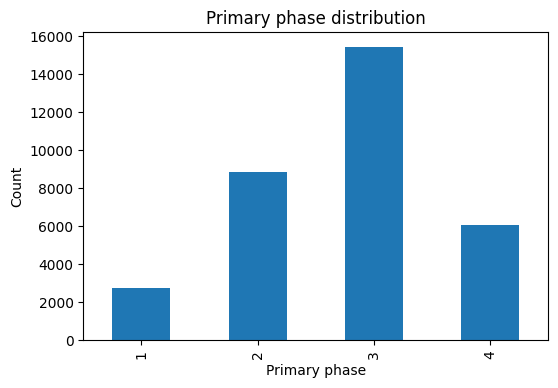

In [8]:
# Plot primary phase distribution

phase_counts = df["primary_phase"].value_counts().sort_index()
print(phase_counts)

fig, ax = plt.subplots(figsize=(6, 4))

phase_counts.plot(kind="bar", ax=ax)
ax.set_xlabel("Primary phase")
ax.set_ylabel("Count")
ax.set_title("Primary phase distribution")

fig.savefig(
    figure_path / "primary_phase_distribution.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()



In [45]:
# Inspect phase distribution per query_id

phase_query_ct = pd.crosstab(df["query_id"], df["primary_phase"], normalize="index")
phase_query_ct = phase_query_ct.rename(columns=lambda x: f"phase_{x}")

phase_query_ct.head(25)


primary_phase,phase_1,phase_2,phase_3,phase_4
query_id,,,,
ml_anomaly_detection_production,0.003279,0.040984,0.852459,0.103279
ml_automation,0.024777,0.452924,0.408325,0.113974
ml_defect_detection,0.000000,0.380328,0.395082,0.224590
ml_disassembly,0.036900,0.328413,0.409594,0.225092
ml_end_of_life,0.078431,0.078431,0.019608,0.823529
ml_inservice_monitoring,0.101220,0.089024,0.460976,0.348780
ml_manufacturing,0.046148,0.401463,0.407893,0.144496
ml_manufacturing_optimization,0.076703,0.531205,0.332063,0.060029
ml_planning_production,0.232394,0.190728,0.456573,0.120305


In [46]:
# Show queries most dominated by each phase

for p in [1, 2, 3, 4]:
    col = f"phase_{p}"
    print(f"\nTop queries for {col}:")
    display(phase_query_ct[col].sort_values(ascending=False).head(10))



Top queries for phase_1:


query_id
ml_product_development           0.241997
ml_planning_production           0.232394
ml_product_design                0.221782
ml_sustainability_product        0.185279
ml_production_optimization       0.182356
ml_supply_chain                  0.127298
ml_process_modeling              0.107527
ml_inservice_monitoring          0.101220
ml_end_of_life                   0.078431
ml_manufacturing_optimization    0.076703
Name: phase_1, dtype: float64


Top queries for phase_2:


query_id
ml_process_optimization          0.552448
ml_robotics_production           0.545580
ml_manufacturing_optimization    0.531205
ml_automation                    0.452924
ml_product_design                0.404950
ml_manufacturing                 0.401463
ml_defect_detection              0.380328
ml_recycling_manufacturing       0.359223
ml_quality_control               0.346112
ml_remanufacturing               0.333333
Name: phase_2, dtype: float64


Top queries for phase_3:


query_id
ml_anomaly_detection_production    0.852459
ml_process_control                 0.706804
ml_process_modeling                0.629800
ml_predictive_maintenance          0.613770
ml_production_optimization         0.587347
ml_quality_control                 0.561884
ml_inservice_monitoring            0.460976
ml_planning_production             0.456573
ml_disassembly                     0.409594
ml_automation                      0.408325
Name: phase_3, dtype: float64


Top queries for phase_4:


query_id
ml_end_of_life                0.823529
ml_rul                        0.630605
ml_remanufacturing            0.515152
ml_recycling_manufacturing    0.514563
ml_sustainability_product     0.402284
ml_plm                        0.371179
ml_predictive_maintenance     0.353115
ml_inservice_monitoring       0.348780
ml_supply_chain               0.272984
ml_product_development        0.229193
Name: phase_4, dtype: float64

In [47]:
# Compute confidence metrics for phase assignment

df["phase_max_prob"] = df[["phase_p1", "phase_p2", "phase_p3", "phase_p4"]].max(axis=1)

# Gap between primary and secondary phases
sorted_probs = np.sort(df[["phase_p1", "phase_p2", "phase_p3", "phase_p4"]].values, axis=1)
df["phase_margin"] = sorted_probs[:, -1] - sorted_probs[:, -2]

df[["primary_phase", "secondary_phase", "phase_max_prob", "phase_margin"]].describe()


,primary_phase,secondary_phase,phase_max_prob,phase_margin
count,33130.000000,33130.000000,33130.000000,3.313000e+04
mean,2.747902,2.711832,0.266492,1.154863e-02
std,0.848058,1.056950,0.008676,9.660461e-03
min,1.000000,1.000000,0.250300,3.407816e-07
25%,2.000000,2.000000,0.259884,4.051039e-03
50%,3.000000,3.000000,0.265153,9.149597e-03
75%,3.000000,4.000000,0.271779,1.668559e-02
max,4.000000,4.000000,0.316873,7.458706e-02


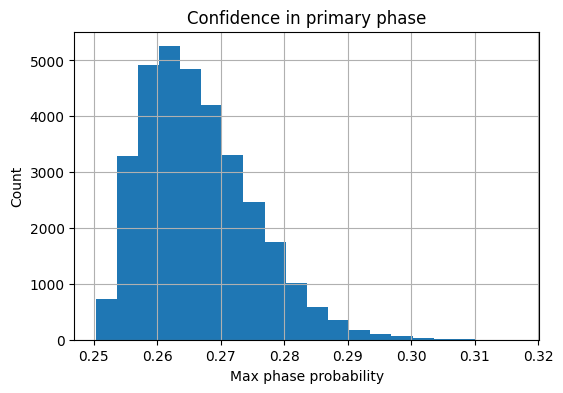

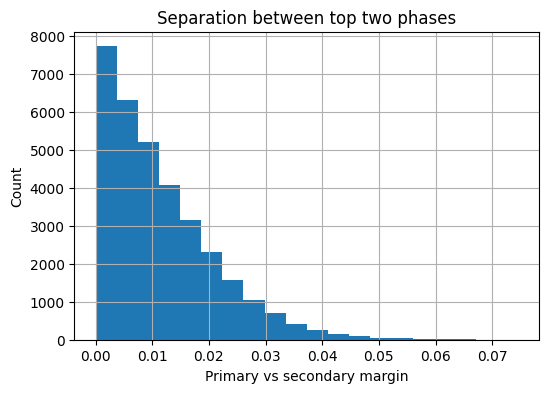

In [9]:
# Confidence in primary phase
fig, ax = plt.subplots(figsize=(6, 4))
df["phase_max_prob"].hist(bins=20, ax=ax)
ax.set_xlabel("Max phase probability")
ax.set_ylabel("Count")
ax.set_title("Confidence in primary phase")

fig.savefig(
    figure_path / "phase_confidence_distribution.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


# Separation between top two phases
fig, ax = plt.subplots(figsize=(6, 4))
df["phase_margin"].hist(bins=20, ax=ax)
ax.set_xlabel("Primary vs secondary margin")
ax.set_ylabel("Count")
ax.set_title("Separation between top two phases")

fig.savefig(
    figure_path / "phase_margin_distribution.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


In [73]:
# Inspect low-confidence samples

low_conf_mask = df["phase_max_prob"] < 0.27
print(f"Low-confidence abstracts (<0.27): {low_conf_mask.sum()}")

df_low_conf = df[low_conf_mask].sort_values("phase_max_prob").head(20)
df_low_conf[[
    "query_id",
    "doi",
    "primary_phase",
    "secondary_phase",
    "phase_p1",
    "phase_p2",
    "phase_p3",
    "phase_p4",
    "clean_abs"
]]


Low-confidence abstracts (<0.27): 22962


,query_id,doi,primary_phase,secondary_phase,phase_p1,phase_p2,phase_p3,phase_p4,clean_abs
1519,ml_automation,10.1557/s43577-023-00490-y,2,4,0.249257,0.250300,0.250151,0.250292,Low-dimensional hybrid perovskites combine the...
21343,ml_manufacturing_optimization,10.1007/978-3-031-96631-6_21,1,3,0.250432,0.250224,0.250274,0.249070,Artificial intelligence (AI) fundamentally tra...
44555,ml_production_optimization,10.18687/LACCEI2022.1.1.616,4,1,0.250438,0.249131,0.249929,0.250501,All rights reserved.The problem addressed the ...
17996,ml_manufacturing,10.1080/02580136.2021.1941652,2,1,0.250410,0.250506,0.248922,0.250162,The Fourth Industrial Revolution (4IR) and acc...
21682,ml_manufacturing_optimization,10.1016/j.optcom.2025.131916,4,2,0.248738,0.250425,0.250288,0.250549,V.Perovskite solar cells (PSCs) are gaining at...
51525,ml_sustainability_product,10.1016/j.biombioe.2024.107490,1,4,0.250578,0.249479,0.249865,0.250078,"In this study, activated carbon derived from s..."
10477,ml_manufacturing,10.1007/s00170-024-14812-0,2,1,0.250661,0.250670,0.248385,0.250283,", part of Springer Nature 2024.In this article..."
40092,ml_production_optimization,10.3390/en18102523,4,2,0.249451,0.250039,0.249791,0.250720,Unconventional reservoirs are characterized by...
17160,ml_manufacturing,10.3390/pr9071157,1,3,0.250833,0.249540,0.250148,0.249479,"Licensee MDPI, Basel, Switzerland.Suppliers ar..."
42526,ml_production_optimization,10.15530/urtec-2024-4044069,3,4,0.249808,0.249482,0.250868,0.249841,"Copyright 2024, Unconventional Resources Techn..."


In [50]:
# Aggregate mean phase probabilities per query_id

phase_prob_cols = ["phase_p1", "phase_p2", "phase_p3", "phase_p4"]
query_phase_means = df.groupby("query_id")[phase_prob_cols].mean()

query_phase_means.head()


,phase_p1,phase_p2,phase_p3,phase_p4
query_id,,,,
ml_anomaly_detection_production,0.228491,0.245115,0.272119,0.254275
ml_automation,0.235792,0.258594,0.257344,0.248270
ml_defect_detection,0.227845,0.258287,0.259153,0.254716
ml_disassembly,0.242519,0.252150,0.253579,0.251751
ml_end_of_life,0.241770,0.246563,0.242454,0.269213


In [51]:
# Show queries with highest mean probability for each phase

for i, col in enumerate(phase_prob_cols, start=1):
    print(f"\nTop queries by mean {col}:")
    display(query_phase_means[col].sort_values(ascending=False).head(10))



Top queries by mean phase_p1:


query_id
ml_product_development           0.251337
ml_product_design                0.250946
ml_planning_production           0.249089
ml_sustainability_product        0.248021
ml_production_optimization       0.247463
ml_supply_chain                  0.244893
ml_plm                           0.244240
ml_manufacturing_optimization    0.243733
ml_process_modeling              0.243232
ml_disassembly                   0.242519
Name: phase_p1, dtype: float64


Top queries by mean phase_p2:


query_id
ml_process_optimization          0.261497
ml_robotics_production           0.259366
ml_manufacturing_optimization    0.259096
ml_automation                    0.258594
ml_defect_detection              0.258287
ml_quality_control               0.257940
ml_manufacturing                 0.255850
ml_product_design                0.255711
ml_recycling_manufacturing       0.255153
ml_remanufacturing               0.254897
Name: phase_p2, dtype: float64


Top queries by mean phase_p3:


query_id
ml_anomaly_detection_production    0.272119
ml_predictive_maintenance          0.268147
ml_process_control                 0.267767
ml_rul                             0.266424
ml_quality_control                 0.262540
ml_process_modeling                0.262259
ml_defect_detection                0.259153
ml_process_optimization            0.258440
ml_production_optimization         0.258051
ml_inservice_monitoring            0.257774
Name: phase_p3, dtype: float64


Top queries by mean phase_p4:


query_id
ml_rul                             0.271161
ml_end_of_life                     0.269213
ml_predictive_maintenance          0.263426
ml_remanufacturing                 0.262769
ml_recycling_manufacturing         0.258250
ml_inservice_monitoring            0.255888
ml_defect_detection                0.254716
ml_sustainability_product          0.254293
ml_anomaly_detection_production    0.254275
ml_plm                             0.253356
Name: phase_p4, dtype: float64

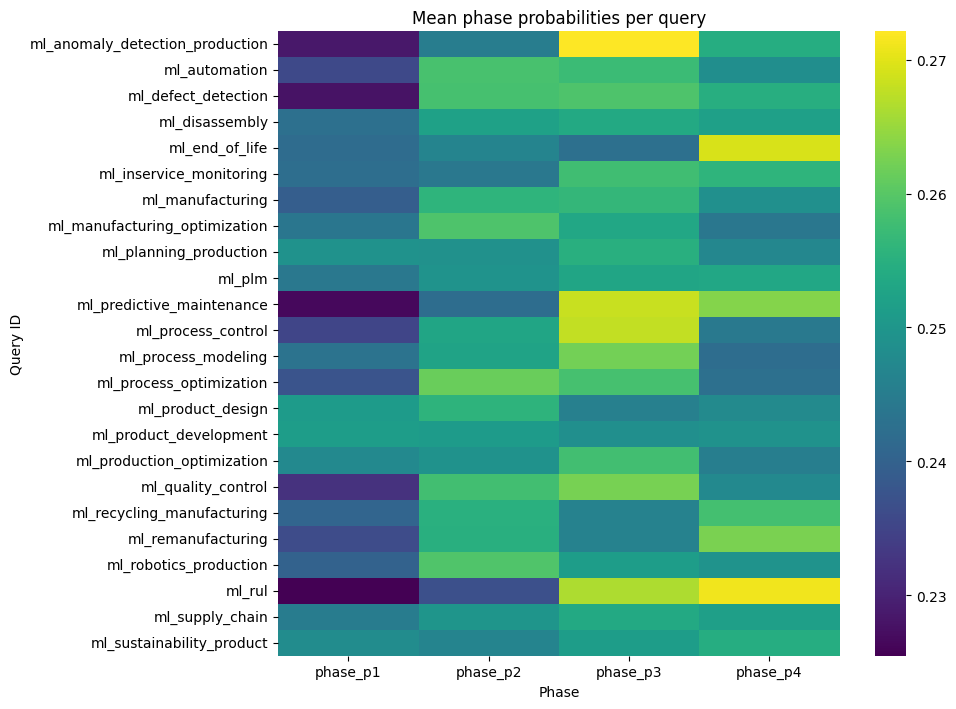

In [ ]:
# Plot heatmap of mean phase probabilities per query_id

plt.figure(figsize=(10, len(query_phase_means) * 0.3))
sns.heatmap(
    query_phase_means[phase_prob_cols],
    annot=False,
    cmap="viridis",
    cbar=True
)
plt.xlabel("Phase")
plt.ylabel("Query ID")
plt.title("Mean phase probabilities per query")
plt.tight_layout()
plt.show()


In [53]:
# Show the most confident abstracts for each phase (primary_phase)
cols_show = [
    "query_id", "doi", "primary_phase", "phase_max_prob", "phase_margin",
    "title", "clean_abs"
]

for p in [1, 2, 3, 4]:
    print(f"\nMost confident Phase {p} abstracts\n")
    
    df_phase = df[df["primary_phase"] == p]
    top_conf = df_phase.sort_values("phase_max_prob", ascending=False).head(5)
    
    display(top_conf[cols_show])



Most confident Phase 1 abstracts



,query_id,doi,primary_phase,phase_max_prob,phase_margin,title,clean_abs
45761,ml_production_optimization,10.1016/j.oregeorev.2019.103015,1,0.284510,0.039980,Lithological mapping in the Central African Co...,The project has received extensive systematic ...
37020,ml_product_design,10.1108/HFF-12-2023-0745,1,0.284166,0.023324,Nacelle optimisation through multi-fidelity ne...,Purpose: Aerodynamic shape optimisation is a c...
45999,ml_production_optimization,10.1007/s11625-017-0521-6,1,0.282672,0.038049,Assessment of mitigation strategies as tools f...,Although the world understands the possible th...
42923,ml_production_optimization,10.18402/resci.2023.12.08,1,0.282217,0.035863,The scene cognition and production mechanism o...,[Objective] Based on the division of the upper...
37221,ml_product_design,10.1145/3640429.3640437,1,0.281799,0.025673,Design Thinking Using Qualitative Data Analysi...,Design Thinking is a human-centered approach t...



Most confident Phase 2 abstracts



,query_id,doi,primary_phase,phase_max_prob,phase_margin,title,clean_abs
8025,ml_manufacturing,10.1007/978-3-031-78747-8,2,0.297410,0.057167,CAD-based Programming for Design and Manufactu...,This book offers a thorough examination of CAD...
48589,ml_robotics_production,10.1007/978-3-030-62746-1_54,2,0.295679,0.045740,Research and Development of Simulation System ...,With the increasing demand for automation of p...
27104,ml_planning_production,10.1109/AI4I49448.2020.00015,2,0.293903,0.048682,Towards a user-centered development process of...,"The paradigm shift in manufacturing, the trans..."
18840,ml_manufacturing,10.1016/j.addma.2019.101003,2,0.293718,0.047741,Building free-form thin shell parts using supp...,V.Conventional material extrusion additive man...
48087,ml_robotics_production,10.54808/ICSIT2025.01.9,2,0.292472,0.036108,Technology Enhanced Teaching for an Industry 4...,All Rights Reserved.The mission of engineering...



Most confident Phase 3 abstracts



,query_id,doi,primary_phase,phase_max_prob,phase_margin,title,clean_abs
18806,ml_manufacturing,10.1109/TII.2019.2940099,3,0.316873,0.074587,Performance Supervised Fault Detection Schemes...,This article addresses performance supervised ...
34552,ml_process_control,10.1080/00207543.2020.1812750,3,0.313953,0.069077,Nonparametric monitoring of multivariate data ...,Process monitoring of multivariate quality att...
33545,ml_process_control,10.1002/qre.3356,3,0.311460,0.061475,A new multivariate extended homogeneously weig...,Statistical process monitoring (SPM) provides ...
35192,ml_process_control,10.1016/j.procir.2015.12.054,3,0.311106,0.073528,Design Performance Analysis of a Self-Organizi...,"In industrial applications, the continuously g..."
34276,ml_process_control,10.1080/00401706.2021.1929493,3,0.310487,0.069121,Transparent Sequential Learning for Statistica...,Machine learning methods have been widely used...



Most confident Phase 4 abstracts



,query_id,doi,primary_phase,phase_max_prob,phase_margin,title,clean_abs
47896,ml_remanufacturing,10.1016/j.wasman.2014.11.024,4,0.300221,0.065357,An investigation of used electronics return fl...,Consumers often have a tendency to store their...
14453,ml_manufacturing,10.1007/978-981-19-6383-4_30,4,0.298301,0.053952,Experimental Analysis on Aging Evaluation of T...,Transformer aging is the most significant feat...
49089,ml_rul,10.1109/TIM.2025.3562242,4,0.296931,0.045549,A Global Adversarial and Local Contrastive Tra...,The transfer learning method can effectively m...
47863,ml_remanufacturing,10.1016/B978-0-323-91134-4.00020-0,4,0.296476,0.051768,"Available technologies for remanufacturing, re...",All rights reserved.Lithium-ion batteries that...
51870,ml_sustainability_product,10.1109/ICASI60819.2024.10547722,4,0.296125,0.050849,Remaining Value Estimation of Smartphones Appl...,The composition of increasing attention to sus...


In [54]:
# Show the least confident abstracts

for p in [1, 2, 3, 4]:
    print(f"\nLeast confident Phase {p} abstracts\n")
    df_phase = df[df["primary_phase"] == p]
    display(df_phase.sort_values("phase_max_prob").head(3)[cols_show])



Least confident Phase 1 abstracts



,query_id,doi,primary_phase,phase_max_prob,phase_margin,title,clean_abs
21343,ml_manufacturing_optimization,10.1007/978-3-031-96631-6_21,1,0.250432,0.000158,AI in the Pharmaceutical Industry: A Shift in ...,Artificial intelligence (AI) fundamentally tra...
51525,ml_sustainability_product,10.1016/j.biombioe.2024.107490,1,0.250578,0.000500,Synthesis and characterization of novel lignoc...,"In this study, activated carbon derived from s..."
17160,ml_manufacturing,10.3390/pr9071157,1,0.250833,0.000685,On the application of ARIMA and LSTM to predic...,"Licensee MDPI, Basel, Switzerland.Suppliers ar..."



Least confident Phase 2 abstracts



,query_id,doi,primary_phase,phase_max_prob,phase_margin,title,clean_abs
1519,ml_automation,10.1557/s43577-023-00490-y,2,0.250300,0.000007,Toward self-organizing low-dimensional organic...,Low-dimensional hybrid perovskites combine the...
17996,ml_manufacturing,10.1080/02580136.2021.1941652,2,0.250506,0.000096,Can Aristotelian virtue theory survive Fourth ...,The Fourth Industrial Revolution (4IR) and acc...
10477,ml_manufacturing,10.1007/s00170-024-14812-0,2,0.250670,0.000009,Correction to: Predicting tool life and sound ...,", part of Springer Nature 2024.In this article..."



Least confident Phase 3 abstracts



,query_id,doi,primary_phase,phase_max_prob,phase_margin,title,clean_abs
42526,ml_production_optimization,10.15530/urtec-2024-4044069,3,0.250868,0.001027,An Innovative Approach to Capture Depletion Im...,"Copyright 2024, Unconventional Resources Techn..."
51577,ml_sustainability_product,10.1016/B978-0-443-15742-4.00027-2,3,0.250911,0.000048,Biofuels,"All rights are reserved, including those for t..."
18927,ml_manufacturing,10.1007/978-3-030-36375-8,3,0.251035,0.000336,Applying Data Science: How to Create Value wit...,This book offers practical guidelines on creat...



Least confident Phase 4 abstracts



,query_id,doi,primary_phase,phase_max_prob,phase_margin,title,clean_abs
44555,ml_production_optimization,10.18687/LACCEI2022.1.1.616,4,0.250501,0.000063,Machine Learning using synthetic data in the s...,All rights reserved.The problem addressed the ...
21682,ml_manufacturing_optimization,10.1016/j.optcom.2025.131916,4,0.250549,0.000124,Investigating the effectiveness of Ca3AsCl3-ba...,V.Perovskite solar cells (PSCs) are gaining at...
40092,ml_production_optimization,10.3390/en18102523,4,0.250720,0.000681,Research on Shale Oil Well Productivity Predic...,Unconventional reservoirs are characterized by...


## Test semantic similarity robustness with artficial abstracts 

In [55]:
def predict_phase_probs(text: str):
    # Compute embedding
    e_abs = get_embedding(text)
    
    # Raw cosine similarities
    sims = np.array([cosine_similarity(e_abs, pe) for pe in phase_embeddings])
    
    # Softmax
    exp_sims = np.exp(sims - np.max(sims))
    probs = exp_sims / np.sum(exp_sims)
    
    # Return both lists
    return probs.tolist(), sims.tolist()


In [56]:
# Extract fake example abstract for plc phase 1

file_path = "../../fake_data/abstract_plc_phase_1.txt"

with open(file_path, "r", encoding="utf-8") as f:
    plc_phase_1_txt = f.read()
    
pred_probs = predict_phase_probs(plc_phase_1_txt)

print("Phase probabilities for fake abstract - phase 1: \n")
print(pred_probs[0])

print("\n\nRaw cosine similarities: \n")
print(pred_probs[1])

Phase probabilities for fake abstract - phase 1: 

[0.2901752533393112, 0.25704480466831364, 0.2191932727349135, 0.23358666925746152]


Raw cosine similarities: 

[0.6413260698318481, 0.5200914144515991, 0.36079487204551697, 0.4243941903114319]


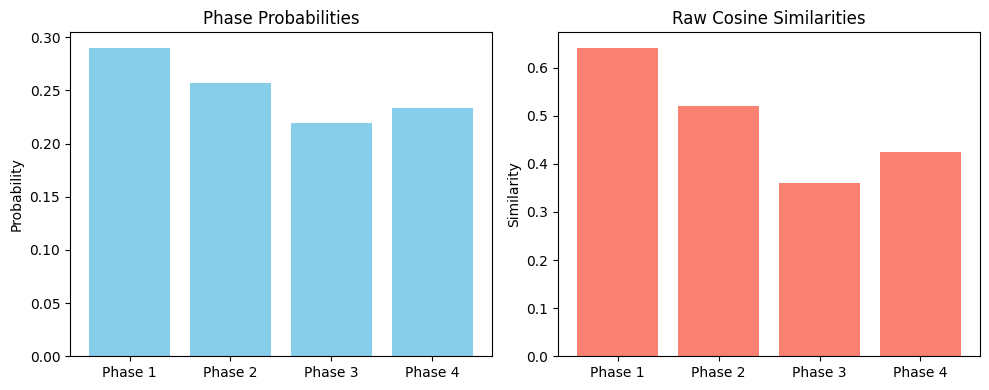

In [57]:
phase_probs = pred_probs[0]
cosine_sims = pred_probs[1]

phases = ['Phase 1', 'Phase 2', 'Phase 3', 'Phase 4']

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].bar(phases, phase_probs, color='skyblue')
axes[0].set_title("Phase Probabilities")
axes[0].set_ylabel("Probability")

axes[1].bar(phases, cosine_sims, color='salmon')
axes[1].set_title("Raw Cosine Similarities")
axes[1].set_ylabel("Similarity")

plt.tight_layout()
plt.show()

In [58]:
# Extract fake example abstract for plc phase 2

file_path = "../../fake_data/abstract_plc_phase_2.txt"

with open(file_path, "r", encoding="utf-8") as f:
    plc_phase_2_txt = f.read()
    
pred_probs = predict_phase_probs(plc_phase_2_txt)

print("Phase probabilities for fake abstract - phase 2: \n")
print(pred_probs[0])

print("\n\nRaw cosine similarities: \n")
print(pred_probs[1])

Phase probabilities for fake abstract - phase 2: 

[0.2279774615694855, 0.28542304124978274, 0.2567494171636405, 0.2298500800170913]


Raw cosine similarities: 

[0.3118351101875305, 0.5365607738494873, 0.43068891763687134, 0.3200156092643738]


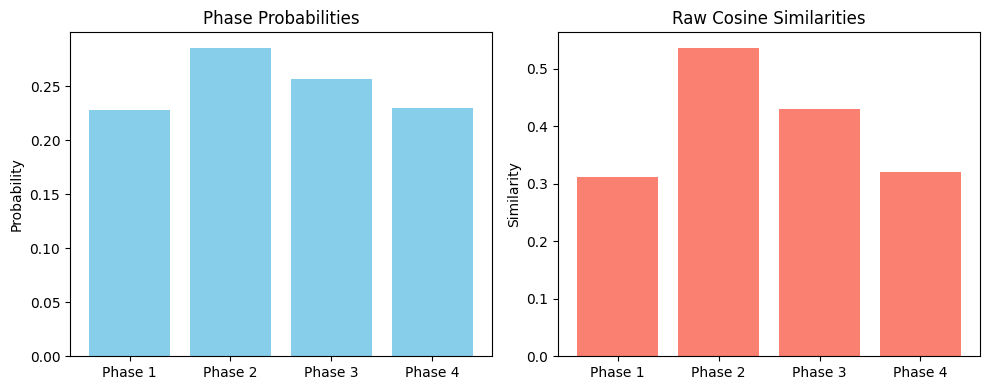

In [59]:
phase_probs = pred_probs[0]
cosine_sims = pred_probs[1]

phases = ['Phase 1', 'Phase 2', 'Phase 3', 'Phase 4']

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].bar(phases, phase_probs, color='skyblue')
axes[0].set_title("Phase Probabilities")
axes[0].set_ylabel("Probability")

axes[1].bar(phases, cosine_sims, color='salmon')
axes[1].set_title("Raw Cosine Similarities")
axes[1].set_ylabel("Similarity")

plt.tight_layout()
plt.show()

In [60]:
# Extract fake example abstract for plc phase 3

file_path = "../../fake_data/abstract_plc_phase_3.txt"

with open(file_path, "r", encoding="utf-8") as f:
    plc_phase_3_txt = f.read()
    
pred_probs = predict_phase_probs(plc_phase_3_txt)

print("Phase probabilities for fake abstract - phase 3: \n")
print(pred_probs[0])

print("\n\nRaw cosine similarities: \n")
print(pred_probs[1])

Phase probabilities for fake abstract - phase 3: 

[0.20457750680159312, 0.24502165542807297, 0.2828988619513142, 0.26750197581901974]


Raw cosine similarities: 

[0.1809091866016388, 0.36130887269973755, 0.5050517320632935, 0.4490892291069031]


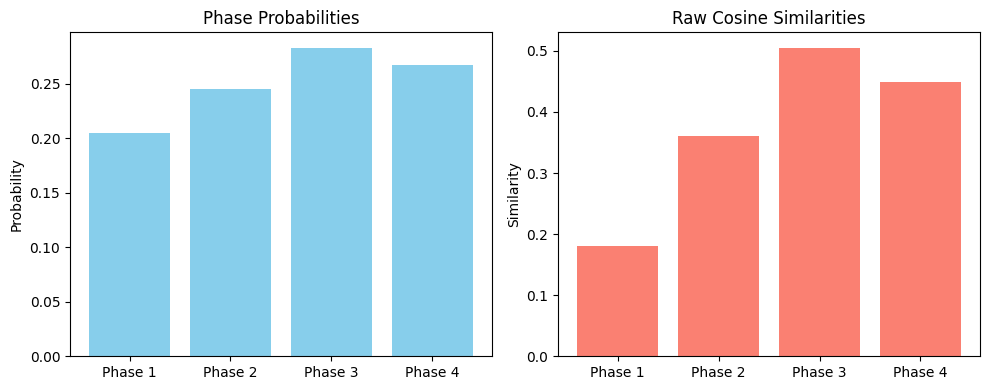

In [61]:
phase_probs = pred_probs[0]
cosine_sims = pred_probs[1]

phases = ['Phase 1', 'Phase 2', 'Phase 3', 'Phase 4']

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].bar(phases, phase_probs, color='skyblue')
axes[0].set_title("Phase Probabilities")
axes[0].set_ylabel("Probability")

axes[1].bar(phases, cosine_sims, color='salmon')
axes[1].set_title("Raw Cosine Similarities")
axes[1].set_ylabel("Similarity")

plt.tight_layout()
plt.show()

In [62]:
# Extract fake example abstract for plc phase 4

file_path = "../../fake_data/abstract_plc_phase_4.txt"

with open(file_path, "r", encoding="utf-8") as f:
    plc_phase_4_txt = f.read()
    
pred_probs = predict_phase_probs(plc_phase_4_txt)

print("Phase probabilities for fake abstract - phase 4: \n")
print(pred_probs[0])

print("\n\nRaw cosine similarities: \n")
print(pred_probs[1])

Phase probabilities for fake abstract - phase 4: 

[0.2188324952659063, 0.24327308780485166, 0.25139281518790196, 0.2865016017413401]


Raw cosine similarities: 

[0.29761528968811035, 0.40349334478378296, 0.43632543087005615, 0.5670528411865234]


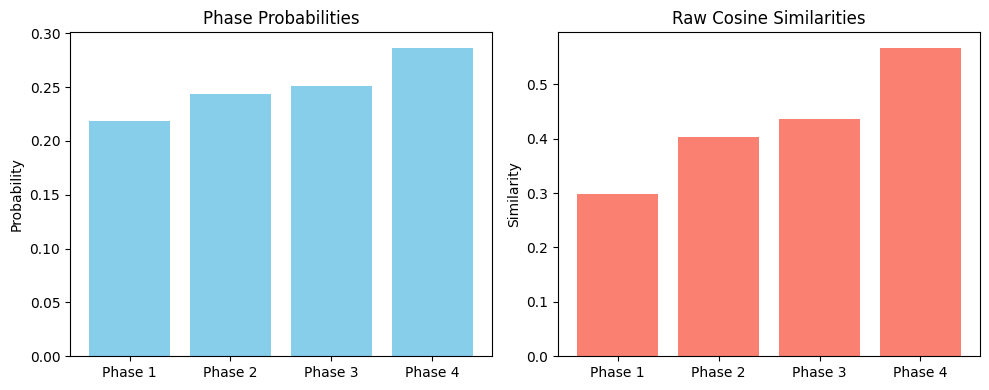

In [63]:
phase_probs = pred_probs[0]
cosine_sims = pred_probs[1]

phases = ['Phase 1', 'Phase 2', 'Phase 3', 'Phase 4']

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].bar(phases, phase_probs, color='skyblue')
axes[0].set_title("Phase Probabilities")
axes[0].set_ylabel("Probability")

axes[1].bar(phases, cosine_sims, color='salmon')
axes[1].set_title("Raw Cosine Similarities")
axes[1].set_ylabel("Similarity")

plt.tight_layout()
plt.show()

In [64]:
# Extract fake example abstract for unclear plc phase

file_path = "../../fake_data/abstract_unclear_phase.txt"

with open(file_path, "r", encoding="utf-8") as f:
    plc_phase_unclear_txt = f.read()
    
pred_probs = predict_phase_probs(plc_phase_unclear_txt)

print("Phase probabilities for fake abstract - unclear: \n")
print(pred_probs[0])

print("\n\nRaw cosine similarities: \n")
print(pred_probs[1])

Phase probabilities for fake abstract - unclear: 

[0.23296346687149405, 0.24423662266840546, 0.2599539920376732, 0.2628459184224273]


Raw cosine similarities: 

[0.4333743453025818, 0.48063021898269653, 0.5429973602294922, 0.554060697555542]


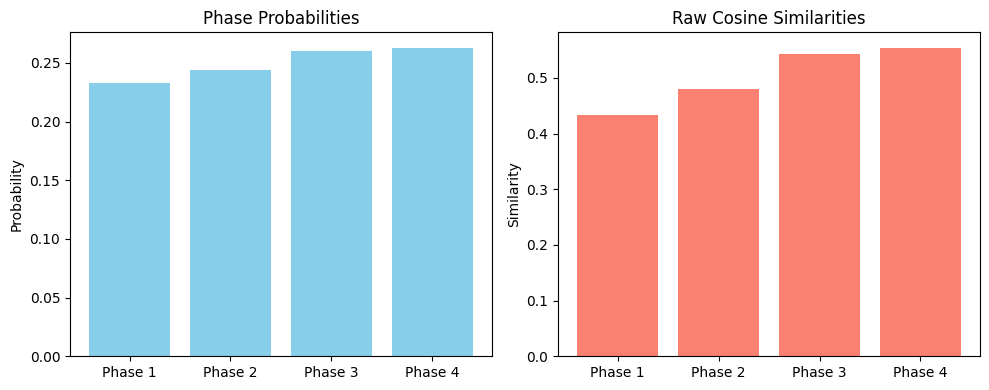

In [65]:
phase_probs = pred_probs[0]
cosine_sims = pred_probs[1]

phases = ['Phase 1', 'Phase 2', 'Phase 3', 'Phase 4']

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].bar(phases, phase_probs, color='skyblue')
axes[0].set_title("Phase Probabilities")
axes[0].set_ylabel("Probability")

axes[1].bar(phases, cosine_sims, color='salmon')
axes[1].set_title("Raw Cosine Similarities")
axes[1].set_ylabel("Similarity")

plt.tight_layout()
plt.show()

## Show distribution of token length per abstract

count    33130.000000
mean       268.794205
std        108.513773
min          1.000000
25%        201.000000
50%        254.000000
75%        315.000000
max       2886.000000
Name: token_count, dtype: float64


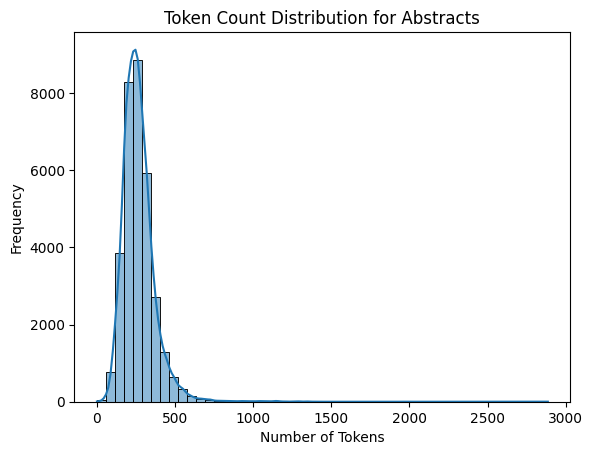

In [66]:
# Use the same model tokenizer used for embeddings
tokenizer = model.tokenizer  

def count_tokens(text):
    # Return token count for each abstract string
    if not isinstance(text, str):
        return 0
    return len(tokenizer.tokenize(text))

# Add a new column with token counts
df["token_count"] = df["clean_abs"].astype(str).apply(count_tokens)

# Show descriptive statistics of token distribution
print(df["token_count"].describe())

# Plot histogram of token distribution
sns.histplot(df["token_count"], bins=50, kde=True)
plt.title("Token Count Distribution for Abstracts")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()


In [67]:
# Get model max sequence length
max_len = model.get_max_seq_length()
print("Model max sequence length:", max_len)

# Compute how many abstracts exceed this length
df["over_max_len"] = df["token_count"] > max_len

num_over = df["over_max_len"].sum()
pct_over = num_over / len(df) * 100

print(f"Abstracts over {max_len} tokens: {num_over} ({pct_over:.2f}%)")


Model max sequence length: 384
Abstracts over 384 tokens: 3390 (10.23%)


In [68]:
# Show the longest abstracts by token count
longest_abs = df.nlargest(10, "token_count")[["doi", "clean_abs", "token_count"]]
display(longest_abs)


,doi,clean_abs,token_count
3313,10.1002/pro.3431,", Duran, M. and Keating, A. E. (2018) Protein ...",2886
50858,10.1016/j.inpa.2023.08.004,"To conform with current best practices, we hav...",2458
39528,10.48308/esrj.2025.232122.1181,Introduction The study and evaluation of hydro...,1959
22960,10.3788/CJL231470,All rights reserved.Significance Extreme ultra...,1614
21937,10.3788/AOS241929,All rights reserved.Objective As one type of n...,1585
837,10.3788/CJL241363,All rights reserved.Significance The research ...,1555
2424,10.3788/CJL241344,All rights reserved.Objective Magnesium alloy ...,1417
51527,10.1016/j.techfore.2024.123908,The aim is to be more effective and efficient ...,1373
21656,10.3788/CJL250774,All rights reserved.Significance Ultrashort pu...,1347
48106,10.12454/j.jsuese.202400072,All rights reserved.Objective This study inves...,1345
